In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
from rdkit.Chem import inchi
import molvs
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Decompdiff
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from Targetdiff

See if they are valid or not and standardize them:

In [4]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [5]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Decompdiff/combined_smiles_decompdiff_10000.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/8607 [00:00<?, ?mol/s]

Standardizing molecules:  22%|██▏       | 1891/8607 [04:31<04:26, 25.23mol/s]  [02:43:27] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[02:43:27] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[02:43:27] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
[02:43:27] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
Standardizing molecules:  77%|███████▋  | 6655/8607 [11:43<08:14,  3.95mol/s]  [02:50:39] Can't kekulize mol.  Unkekulized atoms: 22 23 24 27 29
[02:50:39] Can't kekulize mol.  Unkekulized atoms: 22 23 24 27 29
[02:50:39] Can't kekulize mol.  Unkekulized atoms: 22 23 24 27 29
Standardizing molecules:  98%|█████████▊| 8450/8607 [15:02<00:34,  4.55mol/s] [02:53:58] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 17 19 20 21 22 24 25
[02:53:58] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 17 19 20 21 22 24 25
[02:53:58] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 17 19 20 21 22 24 25
[02:53:58] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 17 

8607


8607

In [6]:
with open('combined_smiles_decompdiff_10000_standardized.txt', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

Convert SMILES and name of them to a dataframe

In [6]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

SMILES
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...
...                                                 ...
8602                            OCC1(O)C(O)CC(O)C(O)C1O
8603                              OC(O)C1N=NC2CC=CCNC21
8604                           NC1C2CCC(C2)CC2NC(=O)C21
8605                                CCC1COCCC(O)C(N)C1O
8606                               NC1CC(CO)OC1CCC(=O)O

[8607 rows x 1 columns]

Add an RDKit molecule to the dataframe

In [7]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

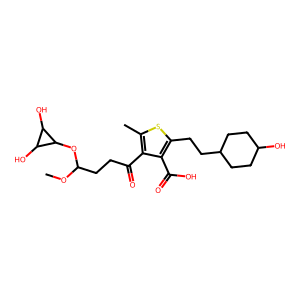

In [8]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [9]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                        [c1ccsc1, C1CCCCC1, C1CC1]
1                      [c1ccoc1, c1ccccc1, c1ccsc1]
2           [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]
3       [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]
4                               [C1CCCC1, c1ccncc1]
                           ...                     
8602                                     [C1CCCCC1]
8603                             [C1=CCC2N=NCC2NC1]
8604                        [O=C1NC2CC3CCC(C3)CC12]
8605                                   [C1CCCOCCC1]
8606                                      [C1CCOC1]
Name: ring_sytems, Length: 8607, dtype: object

In [10]:
df.ring_sytems.values

array([list(['c1ccsc1', 'C1CCCCC1', 'C1CC1']),
       list(['c1ccoc1', 'c1ccccc1', 'c1ccsc1']),
       list(['c1ccccc1', 'C1CCCCC1', 'c1ccsc1', 'c1ccccc1']), ...,
       list(['O=C1NC2CC3CCC(C3)CC12']), list(['C1CCCOCCC1']),
       list(['C1CCOC1'])], dtype=object)

See how many times each ring system occurs

In [11]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

SMILES  Count
4                      c1ccccc1   2805
16                      C1CCOC1    525
7                     C1CCCCCC1    493
9                       C1CCCC1    469
10                     c1ccncc1    350
...                         ...    ...
3524             C1C2CC3NC2CC13      1
3525             C1CC2CSSCC1CN2      1
3526          C1CCC23CCCC2CC3C1      1
3511     O=C1NCCC2NCC3CNNCC3C12      1
3512  C1=CC=c2ccccc2=C2OCOC2=C1      1

[3559 rows x 2 columns]

View the ring system frequencies

In [12]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [13]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [14]:
res

0       [(c1ccsc1, 80452), (C1CCCCC1, 90332), (C1CC1, ...
1       [(c1ccoc1, 72468), (c1ccccc1, 2568039), (c1ccs...
2       [(c1ccccc1, 2568039), (C1CCCCC1, 90332), (c1cc...
3       [(c1cc[nH]c1, 34250), (C1CCNC1, 136431), (C1CC...
4                  [(C1CCCC1, 38317), (c1ccncc1, 275595)]
                              ...                        
8602                                  [(C1CCCCC1, 90332)]
8603                              [(C1=CCC2N=NCC2NC1, 0)]
8604                         [(O=C1NC2CC3CCC(C3)CC12, 0)]
8605                                    [(C1CCCOCCC1, 2)]
8606                                   [(C1CCOC1, 54820)]
Name: mol, Length: 8607, dtype: object

In [15]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
8602                            OCC1(O)C(O)CC(O)C(O)C1O   
8603                              OC(O)C1N=NC2CC=CCNC21   
8604                           NC1C2CCC(C2)CC2NC(=O)C21   
8605                                CCC1COCCC(O)C(N)C1O   
8606                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
8602  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
8603  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
8604  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
8605  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
8606  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]                c1ccsc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
8602                                   [C1CCCCC1]               C1CCCCC1   
8603                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
8604                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
8605                                 [C1CCCOCCC1]             C1CCCOCCC1   
8606                                    [C1CCOC1]                C1CCOC1   

     min_freq  
0       80452  
1       72468  
2       80452  
3        3561  
4       38317  
...       ...  
8602    90332  
8603        0  
8604        0  
8605        2  
8606    54820  

[8607 rows x 5 columns]

In [16]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [17]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Proton(s) added/removed; Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41] WARNING: Omitted undefined stereo

[15:08:41

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]                c1ccsc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
7990                                   [C1CCCCC1]               C1CCCCC1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

     min_freq                                              inchi  
0       80452  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...  
1       72468  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...  
2       80452  InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...  
3        3561  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...  
4       38317  InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...  
...       ...                                                ...  
7990    90332  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...  
7991        0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...  
7992        0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...  
7993        2  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...  
7994    54820  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...  

[7995 rows x 6 columns]

How many molecules contains ring structure?

In [18]:
df_ring = df[df.min_freq != -1]
df_ring

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]                c1ccsc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
7990                                   [C1CCCCC1]               C1CCCCC1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

     min_freq                                              inchi  
0       80452  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...  
1       72468  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...  
2       80452  InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...  
3        3561  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...  
4       38317  InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...  
...       ...                                                ...  
7990    90332  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...  
7991        0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...  
7992        0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...  
7993        2  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...  
7994    54820  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...  

[7442 rows x 6 columns]

In [19]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7975                               OCC1CC(O)C(C=NO)CC1O   
7976                            OC1OCC(O)C(O)(C2CO2)C1O   
7977                            OC(O)C1OC(O)C(O)C(O)C1O   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7975  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa340>   
7976  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa3b0>   
7977  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa420>   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems   min_ring min_freq  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]    c1ccsc1    80452   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]    c1ccoc1    72468   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]    c1ccsc1    80452   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]  C1CCCCCC1     3561   
4                             [C1CCCC1, c1ccncc1]    C1CCCC1    38317   
...                                           ...        ...      ...   
7975                                   [C1CCCCC1]   C1CCCCC1    90332   
7976                            [C1CCOCC1, C1CO1]      C1CO1     3085   
7977                                   [C1CCOCC1]   C1CCOCC1    74445   
7990                                   [C1CCCCC1]   C1CCCCC1    90332   
7994                                    [C1CCOC1]    C1CCOC1    54820   

                                                  inchi  
0     InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...  
1     InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...  
2     InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...  
3     InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...  
4     InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...  
...                                                 ...  
7975  InChI=1S/C8H15NO4/c10-4-6-2-7(11)5(3-9-13)1-8(...  
7976  InChI=1S/C7H12O6/c8-3-1-13-6(10)5(9)7(3,11)4-2...  
7977  InChI=1S/C6H12O7/c7-1-2(8)4(5(10)11)13-6(12)3(...  
7990  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...  
7994  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...  

[3411 rows x 6 columns]

### How many of them could pass PAINS filter?

Get a list of rules

In [20]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [21]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [22]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [23]:
reos.pandas_mols(df.mol)

  0%|          | 0/7995 [00:00<?, ?it/s]

rule_set_name description
0               ok          ok
1               ok          ok
2               ok          ok
3               ok          ok
4               ok          ok
...            ...         ...
7990            ok          ok
7991            ok          ok
7992            ok          ok
7993            ok          ok
7994            ok          ok

[7995 rows x 2 columns]

In [24]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/7995 [00:00<?, ?it/s]

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]                c1ccsc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
7990                                   [C1CCCCC1]               C1CCCCC1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

     min_freq                                              inchi  \
0       80452  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...   
1       72468  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...   
2       80452  InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...   
3        3561  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...   
4       38317  InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...   
...       ...                                                ...   
7990    90332  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...   
7991        0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...   
7992        0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...   
7993        2  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...   
7994    54820  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...   

     rule_set_name description  
0               ok          ok  
1               ok          ok  
2               ok          ok  
3               ok          ok  
4               ok          ok  
...            ...         ...  
7990            ok          ok  
7991            ok          ok  
7992            ok          ok  
7993            ok          ok  
7994            ok          ok  

[7715 rows x 8 columns]

Test all filters from rd_filters

In [25]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/7995 [00:00<?, ?it/s]

Glaxo 0.88317698561601 ['Glaxo'] 7061


  0%|          | 0/7995 [00:00<?, ?it/s]

Dundee 0.3798624140087555 ['Dundee'] 3037


  0%|          | 0/7995 [00:00<?, ?it/s]

BMS 0.6993120700437774 ['BMS'] 5591


  0%|          | 0/7995 [00:00<?, ?it/s]

SureChEMBL 0.7337085678549093 ['SureChEMBL'] 5866


  0%|          | 0/7995 [00:00<?, ?it/s]

MLSMR 0.46741713570981863 ['MLSMR'] 3737


  0%|          | 0/7995 [00:00<?, ?it/s]

Inpharmatica 0.690181363352095 ['Inpharmatica'] 5518


  0%|          | 0/7995 [00:00<?, ?it/s]

LINT 0.5129455909943715 ['LINT'] 4101


### How many of them could pass filters suggested by Dr.Reymond?

In [26]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]                c1ccsc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
7990                                   [C1CCCCC1]               C1CCCCC1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

     min_freq                                              inchi  Reymond  
0       80452  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True  
1       72468  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True  
2       80452  InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True  
3        3561  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True  
4       38317  InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True  
...       ...                                                ...      ...  
7990    90332  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True  
7991        0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...     True  
7992        0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...     True  
7993        2  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True  
7994    54820  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True  

[7995 rows x 7 columns]

In [27]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]                c1ccsc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
7990                                   [C1CCCCC1]               C1CCCCC1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

     min_freq                                              inchi  Reymond  
0       80452  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True  
1       72468  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True  
2       80452  InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True  
3        3561  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True  
4       38317  InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True  
...       ...                                                ...      ...  
7990    90332  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True  
7991        0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...     True  
7992        0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...     True  
7993        2  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True  
7994    54820  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True  

[7830 rows x 7 columns]

### How many of them could pass RO5?

In [28]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]                c1ccsc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
7990                                   [C1CCCCC1]               C1CCCCC1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

     min_freq                                              inchi  Reymond  \
0       80452  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True   
1       72468  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True   
2       80452  InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True   
3        3561  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True   
4       38317  InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True   
...       ...                                                ...      ...   
7990    90332  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True   
7991        0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...     True   
7992        0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...     True   
7993        2  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True   
7994    54820  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True   

      Lipinski  
0         True  
1         True  
2        False  
3         True  
4        False  
...        ...  
7990     False  
7991      True  
7992      True  
7993      True  
7994      True  

[7995 rows x 8 columns]

In [29]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
5     CC1CN(C(CC2CN=C(NCCCN)C2C)C(=O)O)CC1C1CN(C(N)=...   
6     CC1CCC(CCCC2CCN(CCCCO)C2)(C(N)=O)C1c1ccc2c(c1)...   
...                                                 ...   
7989                               CC1C(=N)NC2NCCC2CN1C   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
5     <rdkit.Chem.rdchem.Mol object at 0x79cf92d097e0>   
6     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09850>   
...                                                ...   
7989  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa960>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
5                  [C1CCNC1, C1=NCCC1, O=C1CCNN1]              O=C1CCNN1   
6             [C1CCCC1, C1CCNC1, c1ccc2c(c1)CNC2]        c1ccc2c(c1)CNC2   
...                                           ...                    ...   
7989                           [N=C1CNCC2CCNC2N1]       N=C1CNCC2CCNC2N1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

     min_freq                                              inchi  Reymond  \
0       80452  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True   
1       72468  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True   
3        3561  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True   
5         141  InChI=1S/C20H35N7O4/c1-11-8-26(9-14(11)15-10-2...     True   
6        3120  InChI=1S/C26H41N3O2/c1-19-8-11-26(25(27)31,24(...     True   
...       ...                                                ...      ...   
7989        0  InChI=1S/C9H18N4/c1-6-8(10)12-9-7(3-4-11-9)5-1...     True   
7991        0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...     True   
7992        0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...     True   
7993        2  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True   
7994    54820  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True   

      Lipinski  
0         True  
1         True  
3         True  
5         True  
6         True  
...        ...  
7989      True  
7991      True  
7992      True  
7993      True  
7994      True  

[6162 rows x 8 columns]

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [30]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0       [(c1ccsc1, 5148488832), (C1CCCCC1, 4295567520)...
1       [(c1ccoc1, 3435465796), (c1ccccc1, 21243538754...
2       [(c1ccccc1, 21243538754), (C1CCCCC1, 429556752...
3       [(c1cc[nH]c1, 2459540094), (C1CCNC1, 147630484...
4         [(C1CCCC1, 5317217694), (c1ccncc1, 9975620076)]
                              ...                        
7990                             [(C1CCCCC1, 4295567520)]
7991                              [(C1=CCC2N=NCC2NC1, 0)]
7992                         [(O=C1NC2CC3CCC(C3)CC12, 0)]
7993                                [(C1CCCOCCC1, 46224)]
7994                              [(C1CCOC1, 4151021098)]
Name: mol, Length: 7995, dtype: object

In [31]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]               C1CCCCC1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]               C1CCCCC1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
7990                                   [C1CCCCC1]               C1CCCCC1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

        min_freq                                              inchi  Reymond  \
0     4295567520  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True   
1     3435465796  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True   
2     4295567520  InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True   
3      481701208  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True   
4     5317217694  InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True   
...          ...                                                ...      ...   
7990  4295567520  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True   
7991           0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...     True   
7992           0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...     True   
7993       46224  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True   
7994  4151021098  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True   

      Lipinski  
0         True  
1         True  
2        False  
3         True  
4        False  
...        ...  
7990     False  
7991      True  
7992      True  
7993      True  
7994      True  

[7995 rows x 8 columns]

In [32]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [33]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7979                          OC1CCC2(O)C(O)C(O)C(O)C12   
7984                           O=C1C(O)C(O)NC(O)C(O)C1O   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7979  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa500>   
7984  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa730>   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems      min_ring    min_freq  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]      C1CCCCC1  4295567520   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]       c1ccoc1  3435465796   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]      C1CCCCC1  4295567520   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]     C1CCCCCC1   481701208   
4                             [C1CCCC1, c1ccncc1]       C1CCCC1  5317217694   
...                                           ...           ...         ...   
7979                               [C1CC2CCCC2C1]  C1CC2CCCC2C1     9064982   
7984                                [O=C1CCCNCC1]   O=C1CCCNCC1      462728   
7990                                   [C1CCCCC1]      C1CCCCC1  4295567520   
7993                                 [C1CCCOCCC1]    C1CCCOCCC1       46224   
7994                                    [C1CCOC1]       C1CCOC1  4151021098   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True      True  
1     InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True      True  
2     InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True     False  
3     InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True      True  
4     InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True     False  
...                                                 ...      ...       ...  
7979  InChI=1S/C8H14O5/c9-3-1-2-8(13)4(3)5(10)6(11)7...     True      True  
7984  InChI=1S/C6H11NO6/c8-1-2(9)4(11)6(13)7-5(12)3(...     True     False  
7990  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True     False  
7993  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True      True  
7994  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True      True  

[4111 rows x 8 columns]

In [34]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7985                             CC(O)C1C(=O)C(O)COCC1N   
7987                          OCC1(O)C(O)C(O)C2(CO2)C1O   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7985  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa7a0>   
7987  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa880>   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems       min_ring    min_freq  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]       C1CCCCC1  4295567520   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]        c1ccoc1  3435465796   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]       C1CCCCC1  4295567520   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]      C1CCCCCC1   481701208   
4                             [C1CCCC1, c1ccncc1]        C1CCCC1  5317217694   
...                                           ...            ...         ...   
7985                                [O=C1CCCOCC1]    O=C1CCCOCC1          12   
7987                              [C1CCC2(C1)CO2]  C1CCC2(C1)CO2          38   
7990                                   [C1CCCCC1]       C1CCCCC1  4295567520   
7993                                 [C1CCCOCCC1]     C1CCCOCCC1       46224   
7994                                    [C1CCOC1]        C1CCOC1  4151021098   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True      True  
1     InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True      True  
2     InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True     False  
3     InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True      True  
4     InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True     False  
...                                                 ...      ...       ...  
7985  InChI=1S/C8H15NO4/c1-4(10)7-5(9)2-13-3-6(11)8(...     True      True  
7987  InChI=1S/C7H12O6/c8-1-6(12)3(9)4(10)7(2-13-7)5...     True      True  
7990  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True     False  
7993  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True      True  
7994  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True      True  

[4475 rows x 8 columns]

In [35]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7985                             CC(O)C1C(=O)C(O)COCC1N   
7987                          OCC1(O)C(O)C(O)C2(CO2)C1O   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7985  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa7a0>   
7987  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa880>   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems       min_ring    min_freq  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]       C1CCCCC1  4295567520   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]        c1ccoc1  3435465796   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]       C1CCCCC1  4295567520   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]      C1CCCCCC1   481701208   
4                             [C1CCCC1, c1ccncc1]        C1CCCC1  5317217694   
...                                           ...            ...         ...   
7985                                [O=C1CCCOCC1]    O=C1CCCOCC1          12   
7987                              [C1CCC2(C1)CO2]  C1CCC2(C1)CO2          38   
7990                                   [C1CCCCC1]       C1CCCCC1  4295567520   
7993                                 [C1CCCOCCC1]     C1CCCOCCC1       46224   
7994                                    [C1CCOC1]        C1CCOC1  4151021098   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True      True  
1     InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True      True  
2     InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True     False  
3     InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True      True  
4     InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True     False  
...                                                 ...      ...       ...  
7985  InChI=1S/C8H15NO4/c1-4(10)7-5(9)2-13-3-6(11)8(...     True      True  
7987  InChI=1S/C7H12O6/c8-1-6(12)3(9)4(10)7(2-13-7)5...     True      True  
7990  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True     False  
7993  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True      True  
7994  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True      True  

[4269 rows x 8 columns]

### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [36]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0       [(c1ccsc1, 33752004), (C1CCCCC1, 40360716), (C...
1       [(c1ccoc1, 33401025), (c1ccccc1, 503413992), (...
2       [(c1ccccc1, 503413992), (C1CCCCC1, 40360716), ...
3       [(c1cc[nH]c1, 23589297), (C1CCNC1, 136781602),...
4            [(C1CCCC1, 34084223), (c1ccncc1, 110130832)]
                              ...                        
7990                               [(C1CCCCC1, 40360716)]
7991                              [(C1=CCC2N=NCC2NC1, 0)]
7992                         [(O=C1NC2CC3CCC(C3)CC12, 0)]
7993                                   [(C1CCCOCCC1, 13)]
7994                                [(C1CCOC1, 34263706)]
Name: mol, Length: 7995, dtype: object

In [37]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7991                              OC(O)C1N=NC2CC=CCNC21   
7992                           NC1C2CCC(C2)CC2NC(=O)C21   
7993                                CCC1COCCC(O)C(N)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7991  <rdkit.Chem.rdchem.Mol object at 0x79cf923faa40>   
7992  <rdkit.Chem.rdchem.Mol object at 0x79cf923faab0>   
7993  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab20>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems               min_ring  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]                c1ccsc1   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]                c1ccoc1   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]                c1ccsc1   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]              C1CCCCCC1   
4                             [C1CCCC1, c1ccncc1]                C1CCCC1   
...                                           ...                    ...   
7990                                   [C1CCCCC1]               C1CCCCC1   
7991                           [C1=CCC2N=NCC2NC1]       C1=CCC2N=NCC2NC1   
7992                      [O=C1NC2CC3CCC(C3)CC12]  O=C1NC2CC3CCC(C3)CC12   
7993                                 [C1CCCOCCC1]             C1CCCOCCC1   
7994                                    [C1CCOC1]                C1CCOC1   

      min_freq                                              inchi  Reymond  \
0     33752004  InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True   
1     33401025  InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True   
2     33752004  InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True   
3      2033754  InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True   
4     34084223  InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True   
...        ...                                                ...      ...   
7990  40360716  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True   
7991         0  InChI=1S/C8H13N3O2/c12-8(13)7-6-5(10-11-7)3-1-...     True   
7992         0  InChI=1S/C10H16N2O/c11-9-6-2-1-5(3-6)4-7-8(9)1...     True   
7993        13  InChI=1S/C9H19NO3/c1-2-6-5-13-4-3-7(11)8(10)9(...     True   
7994  34263706  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True   

      Lipinski  
0         True  
1         True  
2        False  
3         True  
4        False  
...        ...  
7990     False  
7991      True  
7992      True  
7993      True  
7994      True  

[7995 rows x 8 columns]

In [38]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [39]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
0     COC(CCC(=O)c1c(C)sc(CCC2CCC(O)CC2)c1C(=O)O)OC1...   
1     CC(NCCC(N)c1c(C(=O)O)coc1COc1ccc(C=NO)cc1)c1cccs1   
2     Cc1cc(NC2CCC(c3cccs3)CC2)c(C(=O)O)cc1Nc1cc(O)c...   
3     Cn1cc(C2CCCN2)cc1CC1CCCC(C2CCNC(N)CC2Cl)CC1C(=O)O   
4     CCC(O)CNCC(CO)N(C)C1CCC(C)(Cc2cncc(C(=N)N)c2)C...   
...                                                 ...   
7976                            OC1OCC(O)C(O)(C2CO2)C1O   
7977                            OC(O)C1OC(O)C(O)C(O)C1O   
7984                           O=C1C(O)C(O)NC(O)C(O)C1O   
7990                            OCC1(O)C(O)CC(O)C(O)C1O   
7994                               NC1CC(CO)OC1CCC(=O)O   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x79cf92d095b0>   
1     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09620>   
2     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09690>   
3     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09700>   
4     <rdkit.Chem.rdchem.Mol object at 0x79cf92d09770>   
...                                                ...   
7976  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa3b0>   
7977  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa420>   
7984  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa730>   
7990  <rdkit.Chem.rdchem.Mol object at 0x79cf923fa9d0>   
7994  <rdkit.Chem.rdchem.Mol object at 0x79cf923fab90>   

                                      ring_sytems     min_ring  min_freq  \
0                      [c1ccsc1, C1CCCCC1, C1CC1]      c1ccsc1  33752004   
1                    [c1ccoc1, c1ccccc1, c1ccsc1]      c1ccoc1  33401025   
2         [c1ccccc1, C1CCCCC1, c1ccsc1, c1ccccc1]      c1ccsc1  33752004   
3     [c1cc[nH]c1, C1CCNC1, C1CCCCCC1, C1CCCNCC1]    C1CCCCCC1   2033754   
4                             [C1CCCC1, c1ccncc1]      C1CCCC1  34084223   
...                                           ...          ...       ...   
7976                            [C1CCOCC1, C1CO1]        C1CO1      8209   
7977                                   [C1CCOCC1]     C1CCOCC1  27461873   
7984                                [O=C1CCCNCC1]  O=C1CCCNCC1       740   
7990                                   [C1CCCCC1]     C1CCCCC1  40360716   
7994                                    [C1CCOC1]      C1CCOC1  34263706   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C22H32O8S/c1-11-17(14(24)8-10-16(29-2...     True      True  
1     InChI=1S/C22H25N3O5S/c1-14(20-3-2-10-31-20)24-...     True      True  
2     InChI=1S/C24H25FN2O3S/c1-14-11-21(26-16-6-4-15...     True     False  
3     InChI=1S/C24H39ClN4O2/c1-29-14-17(22-6-3-8-27-...     True      True  
4     InChI=1S/C22H37N5O4/c1-4-17(29)12-26-11-16(13-...     True     False  
...                                                 ...      ...       ...  
7976  InChI=1S/C7H12O6/c8-3-1-13-6(10)5(9)7(3,11)4-2...     True      True  
7977  InChI=1S/C6H12O7/c7-1-2(8)4(5(10)11)13-6(12)3(...     True     False  
7984  InChI=1S/C6H11NO6/c8-1-2(9)4(11)6(13)7-5(12)3(...     True     False  
7990  InChI=1S/C7H14O6/c8-2-7(13)4(10)1-3(9)5(11)6(7...     True     False  
7994  InChI=1S/C8H15NO4/c9-6-3-5(4-10)13-7(6)1-2-8(1...     True      True  

[3772 rows x 8 columns]